In [1]:
import numpy as np
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
# 데이터셋 준비
# 대충 코사인 시그널로 데이터를 만들어냅니다.
signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:, None]

In [3]:
signal_data

array([[1.        ],
       [0.99802673],
       [0.9921147 ],
       ...,
       [0.98228725],
       [0.9921147 ],
       [0.99802673]])

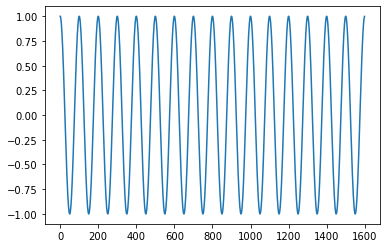

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plot_x = np.arange(1600)
plot_y = signal_data
plt.plot(plot_x, plot_y)
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

In [6]:
# 데이터 분리
train = signal_data[:800]
val = signal_data[800:1200]
test = signal_data[1200:]

In [7]:
train.shape, val.shape, test.shape

((800, 1), (400, 1), (400, 1))

n x 1 array로 하나의 변수를 표현합니다.

In [8]:
#생성한 코사인 데이터를 학습시키기 위해 데이터와 라벨로 구성합니다.
# 이전 수치는 데이터, 다음 수치는 라벨이 됩니다.
# 다른 예제들과는 달리 데이터와 라벨이 모두 같은 속성입니다.

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
look_back = 48

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

In [10]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((752, 48), (752,), (352, 48), (352,), (352, 48), (352,))

In [11]:
x_train[:5]

array([[1.00000000e+00, 9.99013364e-01, 9.96057351e-01, 9.91143625e-01,
        9.84291581e-01, 9.75528258e-01, 9.64888243e-01, 9.52413526e-01,
        9.38153340e-01, 9.22163963e-01, 9.04508497e-01, 8.85256621e-01,
        8.64484314e-01, 8.42273553e-01, 8.18711995e-01, 7.93892626e-01,
        7.67913397e-01, 7.40876837e-01, 7.12889646e-01, 6.84062276e-01,
        6.54508497e-01, 6.24344944e-01, 5.93690657e-01, 5.62666617e-01,
        5.31395260e-01, 5.00000000e-01, 4.68604740e-01, 4.37333383e-01,
        4.06309343e-01, 3.75655056e-01, 3.45491503e-01, 3.15937724e-01,
        2.87110354e-01, 2.59123163e-01, 2.32086603e-01, 2.06107374e-01,
        1.81288005e-01, 1.57726447e-01, 1.35515686e-01, 1.14743379e-01,
        9.54915028e-02, 7.78360372e-02, 6.18466600e-02, 4.75864738e-02,
        3.51117571e-02, 2.44717419e-02, 1.57084194e-02, 8.85637464e-03],
       [9.99013364e-01, 9.96057351e-01, 9.91143625e-01, 9.84291581e-01,
        9.75528258e-01, 9.64888243e-01, 9.52413526e-01, 9.38153

In [12]:
x_test[:5]

array([[1.00000000e+00, 9.99013364e-01, 9.96057351e-01, 9.91143625e-01,
        9.84291581e-01, 9.75528258e-01, 9.64888243e-01, 9.52413526e-01,
        9.38153340e-01, 9.22163963e-01, 9.04508497e-01, 8.85256621e-01,
        8.64484314e-01, 8.42273553e-01, 8.18711995e-01, 7.93892626e-01,
        7.67913397e-01, 7.40876837e-01, 7.12889646e-01, 6.84062276e-01,
        6.54508497e-01, 6.24344944e-01, 5.93690657e-01, 5.62666617e-01,
        5.31395260e-01, 5.00000000e-01, 4.68604740e-01, 4.37333383e-01,
        4.06309343e-01, 3.75655056e-01, 3.45491503e-01, 3.15937724e-01,
        2.87110354e-01, 2.59123163e-01, 2.32086603e-01, 2.06107374e-01,
        1.81288005e-01, 1.57726447e-01, 1.35515686e-01, 1.14743379e-01,
        9.54915028e-02, 7.78360372e-02, 6.18466600e-02, 4.75864738e-02,
        3.51117571e-02, 2.44717419e-02, 1.57084194e-02, 8.85637464e-03],
       [9.99013364e-01, 9.96057351e-01, 9.91143625e-01, 9.84291581e-01,
        9.75528258e-01, 9.64888243e-01, 9.52413526e-01, 9.38153

In [13]:
y_train[:3]

array([0.00394265, 0.00098664, 0.        ])

n x 5 의 array로 각 행은 t 시점부터 t+4 시점까지의 데이터를 표현합니다.<br>
다음 행은 t+1 부터 t+5 시점까지의 데이터를 표현하지요.<br>
타겟 값인 y값은 각 행에서 5번째 값을 가집니다.<br>

즉 이 테이블의 구성은 t ~ t+4 시점의 데이터를 가지고 t+5를 예측,<br>
t+1 ~ t+5 시점의 데이터를 가지고 t+6 을 예측,<br>
i=1~N, t+N ~ t+N+4 -> t+N+5 이렇게 가는 것입니다.

In [14]:
# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
x_train

array([[[1.00000000e+00],
        [9.99013364e-01],
        [9.96057351e-01],
        ...,
        [2.44717419e-02],
        [1.57084194e-02],
        [8.85637464e-03]],

       [[9.99013364e-01],
        [9.96057351e-01],
        [9.91143625e-01],
        ...,
        [1.57084194e-02],
        [8.85637464e-03],
        [3.94264934e-03]],

       [[9.96057351e-01],
        [9.91143625e-01],
        [9.84291581e-01],
        ...,
        [8.85637464e-03],
        [3.94264934e-03],
        [9.86635786e-04]],

       ...,

       [[9.86635786e-04],
        [0.00000000e+00],
        [9.86635786e-04],
        ...,
        [9.64888243e-01],
        [9.75528258e-01],
        [9.84291581e-01]],

       [[0.00000000e+00],
        [9.86635786e-04],
        [3.94264934e-03],
        ...,
        [9.75528258e-01],
        [9.84291581e-01],
        [9.91143625e-01]],

       [[9.86635786e-04],
        [3.94264934e-03],
        [8.85637464e-03],
        ...,
        [9.84291581e-01],
        [9.9114

In [16]:
# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

In [17]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 48, 32)               4352      
_________________________________________________________________
dropout (Dropout)            (1, 48, 32)               0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 48, 32)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (1, 48, 32)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 32)                   8320      
_________________________________________________________________
dropout_2 (Dropout)          (1, 32)                   0         
_________________________________________________________________
dense (Dense)                (1, 1)                    3

In [19]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [21]:
# 4. 모델 학습시키기

custom_hist = CustomHistory()
custom_hist.init()
with tf.device('/cpu:0'):
    for i in range(20):
        model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False,
                  callbacks=[custom_hist], validation_data=(x_val, y_val))
        model.reset_states()

750/752 [============================>.] - ETA: 0s - loss: 0.0787WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002590B074EE8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
752/752 [==============================] - 15s 19ms/step - loss: 0.0088 - val_loss: 0.0215


In [24]:
# 6. 모델 평가하기
with tf.device('/cpu:0'):
    trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
    model.reset_states()
    print('Train Score: ', trainScore)
    valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
    model.reset_states()
    print('Validataion Score: ', valScore)
    testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
    model.reset_states()
    print('Test Score: ', testScore)

Train Score:  0.02057238481938839
Validataion Score:  0.021381042897701263
Test Score:  0.021381042897701263


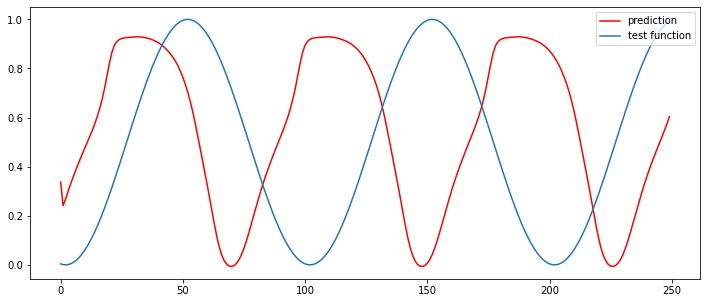

In [26]:
# 7. 모델 사용하기
with tf.device('/cpu:0'):
    look_ahead = 250
    xhat = x_test[0]
    predictions = np.zeros((look_ahead,1))
    for i in range(look_ahead):
        prediction = model.predict(np.array([xhat]), batch_size=1)
        predictions[i] = prediction
        xhat = np.vstack([xhat[1:],prediction])

    plt.figure(figsize=(12,5))
    plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
    plt.plot(np.arange(look_ahead),y_test[:look_ahead],label="test function")
    plt.legend()
    plt.show()

In [ ]:
xhat